# M. Hudson - Assignment 4

Consider the model defined as
$$
Y_i = X_i^T \beta + g(T_i) + \epsilon_i
$$

for $i=1, \ldots, n$, where
- $Y_i \in \mathbb{R}$ is the response variable;
- $X_i \in \mathbb{R}^p$ is a $p$-dimensional vector of covariates (including a constant term);
- $\beta \in \mathbb{R}^p$ is the vector of regression coefficients associated with $X_i$;
- $g(T_i)$ is a nonparametric (unknown) function of $T_i \in \mathbb{R}$, where $T_i$ includes covariates that do not have a linear relationship with the response variable $Y_i$; and
- $\epsilon_i$ is the error term.

In this notebook, I will create a compact software tool that executes this specific regression task.

I have been provided two different datasets, each with different properties. Both datasets have a nonlinear $g$.

In [1]:
# Load required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel

## 1

I will provide a linear regression analysis on these datasets, by treating $(X_i, T_i)$ as inputs and $Y_i$ as the output.

**NOTE:** Throughout this notebook, I will load the data relatively frequently. This is to make each section more readable in isolation, and to avoid complex variable name 


In [2]:
# Load data for dataset 1
X = np.loadtxt('data/data1/X.csv', delimiter=',')
T = np.loadtxt('data/data1/T.csv', delimiter=',').reshape(-1, 1)  # Reshape to make it 2D
Y = np.loadtxt('data/data1/y.csv', delimiter=',')

# Split the data into training and test sets (take 80% of the data for training)
X_and_T = np.concatenate((X, T), axis=1)
X_and_T_train, X_and_T_test, Y_train, Y_test = train_test_split(X_and_T, Y, test_size=0.2, random_state=123456)

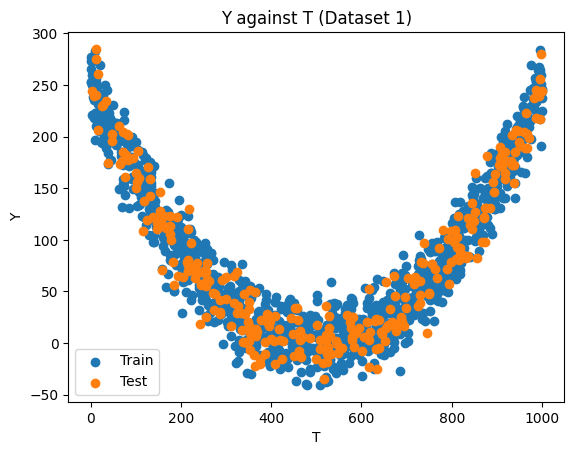

In [3]:
# Plot Y against T to get an intuition how Y varies over time
plt.scatter(X_and_T_train[:, -1], Y_train, label='Train')
plt.scatter(X_and_T_test[:, -1], Y_test, label='Test')
plt.title('Y against T (Dataset 1)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot shows that the test set is randomly chosen from the data.

In [4]:
# Add a constant to the model (the intercept term)
X_and_T_train = sm.add_constant(X_and_T_train)

# Fit the pure linear model
model = sm.OLS(Y_train, X_and_T_train).fit()

# Display the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.205
Date:                Thu, 15 Aug 2024   Prob (F-statistic):           1.90e-09
Time:                        16:52:08   Log-Likelihood:                -6867.2
No. Observations:                1200   AIC:                         1.378e+04
Df Residuals:                    1179   BIC:                         1.388e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.2924      4.332     20.150      0.0

Key points from the results:
- Excluding the constant term, 10 of the covariates have coefficients of zero within the 95% confidence interval. This includes `x20`, which is $T$.
- The result of the Omnibus test is significantly greater than 0. This indicates that the residuals are not normally distributed.
- Similarly, `Prob(JB)` is very close to 0. This also indicates that the residuals are not normally distributed.
- The positive value of skew indicates positive skewness in the residuals, which means that the upper tail of the distribution is longer.
- The value of kurtosis indicates that the distribution of the residuals has light tails and a small peak.
- The result of the Durbin-Watson test is close to 2. This indicates that there is no autocorrelation in the residuals.

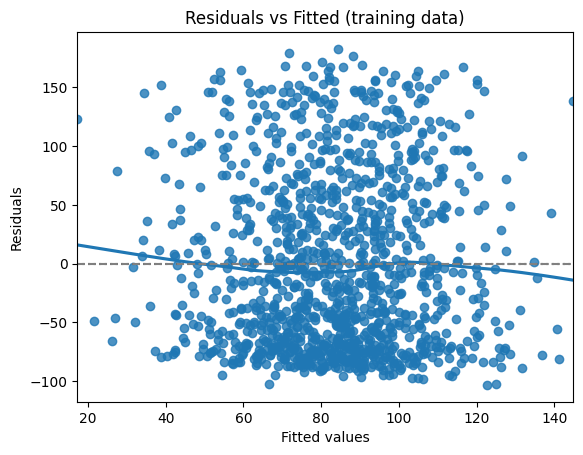

In [5]:
# Plot the residuals against the fitted values
fitted_values = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_values, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs Fitted (training data)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

This plot indicates that the linear regression assumptions are not satisfied. The residuals range from approximately -100 to approximately 175 and are therefore not normally distributed.

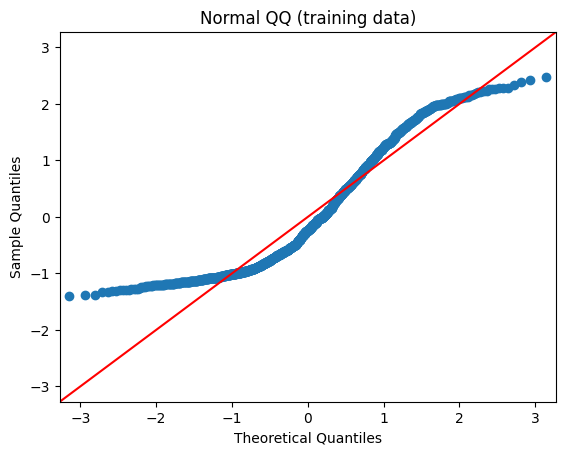

In [6]:
# Plot the Normal QQ plot of the residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal QQ (training data)')
plt.show()

This plot indicates that the linear regression assumptions are not satisfied. Since the data points do not follow a straight line, the QQ plot indicates that the residuals are not normally distributed. 

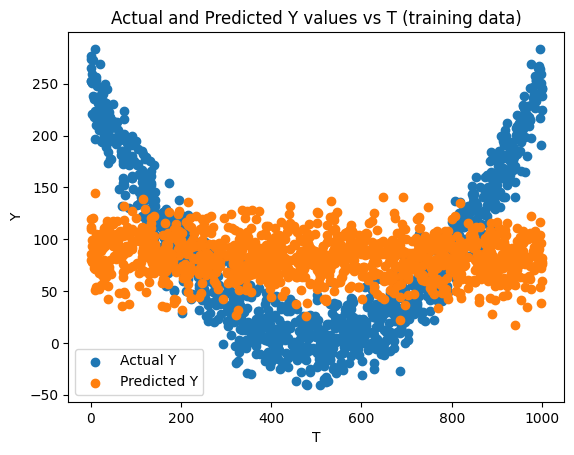

In [7]:
# Plot actual and predicted Y values against T
plt.scatter(X_and_T_train[:, -1], Y_train, label='Actual Y')
plt.scatter(X_and_T_train[:, -1], fitted_values, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot highlights the issue with the pure linear model. There is an unmodelled relationship between $Y$ and $T$. This is not surprising, as we have been told that the relationship is nonlinear.

In [8]:
# Provide the training MSE
mse = mean_squared_error(Y_train, fitted_values)
print('Training MSE: ', mse)

Training MSE:  5472.02900428929


In [9]:
# Compute test error on the test data
X_and_T_test = sm.add_constant(X_and_T_test)
Y_pred = model.predict(X_and_T_test)

# Provide the test MSE
mse = mean_squared_error(Y_test, Y_pred)
print('Test MSE: ', mse)

Test MSE:  5536.446271504557


For the reasons discussed above, the pure linear model is not a good fit for dataset 1.

In [10]:
# Load data for dataset 2
X = np.loadtxt('data/data2/X.csv', delimiter=',')
T = np.loadtxt('data/data2/T.csv', delimiter=',').reshape(-1, 1)  # Reshape to make it 2D
Y = np.loadtxt('data/data2/y.csv', delimiter=',')

# Split the data into training and test sets (take 50% of the data for training)
X_and_T = np.concatenate((X, T), axis=1)
X_and_T_train, X_and_T_test, Y_train, Y_test = train_test_split(X_and_T, Y, test_size=0.5, shuffle=False)

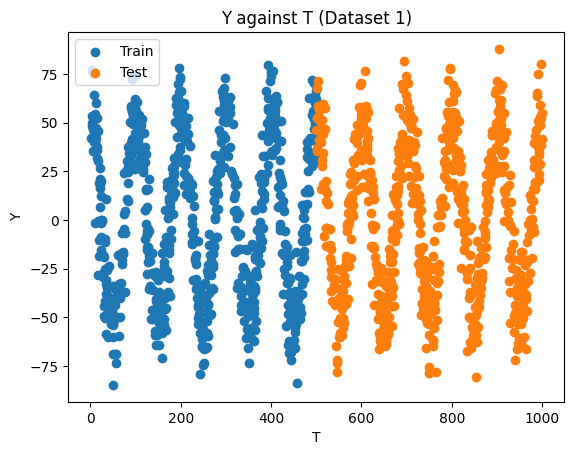

In [11]:
# Plot Y against T to get an intuition how Y varies over time
plt.scatter(X_and_T_train[:, -1], Y_train, label='Train')
plt.scatter(X_and_T_test[:, -1], Y_test, label='Test')
plt.title('Y against T (Dataset 1)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot shows that the test data is outside the range of the training data and follows a clear periodic pattern.

In [12]:
# Add a constant to the model (the intercept term)
X_and_T_train = sm.add_constant(X_and_T_train)

# Fit the pure linear model
model = sm.OLS(Y_train, X_and_T_train).fit()

# Display the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     7.937
Date:                Thu, 15 Aug 2024   Prob (F-statistic):           4.85e-21
Time:                        16:52:09   Log-Likelihood:                -3761.0
No. Observations:                 750   AIC:                             7564.
Df Residuals:                     729   BIC:                             7661.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8276      2.752      0.664      0.5

Key points from the results:
- Excluding the constant term, 13 of the covariates have coefficients of zero within the 95% confidence interval. This includes `x20`, which is $T$.
- The result of the Omnibus test is significantly greater than 0. This indicates that the residuals are not normally distributed.
- Similarly, `Prob(JB)` is very close to 0. This also indicates that the residuals are not normally distributed.
- The value of skew is close to 0. This indicates little skewness in the residuals, which means that the lower and upper tails of the distribution are roughly the same.
- The value of kurtosis indicates that the distribution of the residuals has light tails and a small peak.
- The result of the Durbin-Watson test is close to 0. This indicates that there is a positive autocorrelation in the residuals.

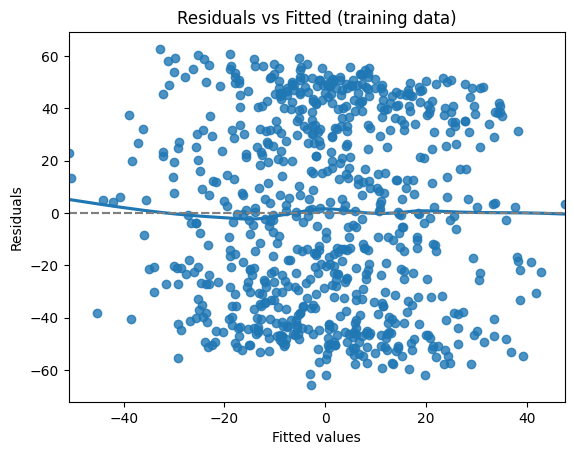

In [13]:
# Plot the residuals against the fitted values
fitted_values = model.fittedvalues
residuals = model.resid
sns.residplot(x=fitted_values, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs Fitted (training data)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

From this plot alone, there is no indication that the linear regression assumptions are not satisfied.

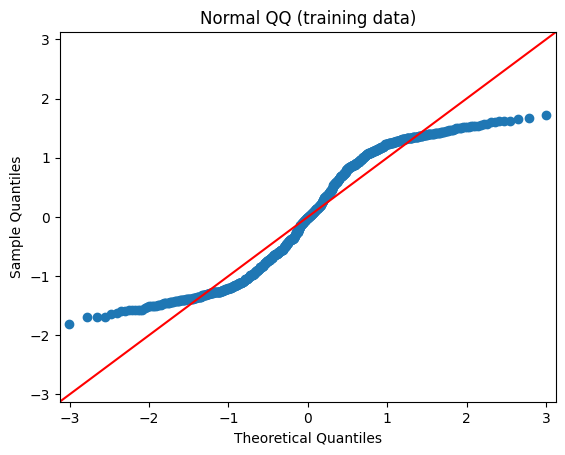

In [14]:
# Plot the Normal QQ plot of the residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal QQ (training data)')
plt.show()

This plot indicates that the linear regression assumptions are not satisfied. Since the data points do not follow a straight line, the QQ plot indicates that the residuals are not normally distributed.

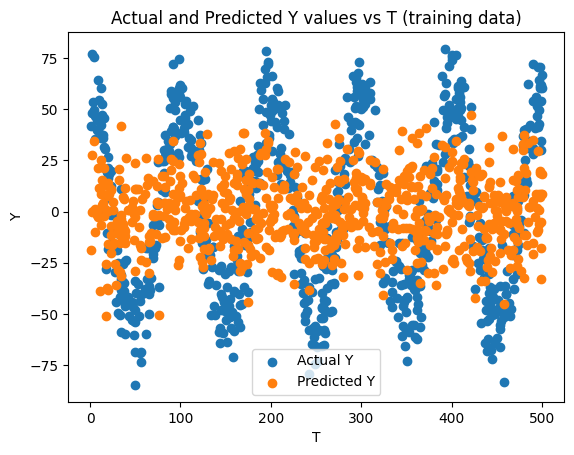

In [15]:
# Plot actual and predicted Y values against T
plt.scatter(X_and_T_train[:, -1], Y_train, label='Actual Y')
plt.scatter(X_and_T_train[:, -1], fitted_values, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot highlights the issue with the pure linear model. There is an unmodelled relationship between $Y$
 an $T$
. This is not surprising, as we have been told that the relationship is nonlinear.

In [16]:
# Provide the training MSE
mse = mean_squared_error(Y_train, fitted_values)
print('Training MSE: ', mse)

Training MSE:  1328.0218387311866


In [17]:
# Compute test error on the test data
X_and_T_test = sm.add_constant(X_and_T_test)
Y_pred = model.predict(X_and_T_test)

# Provide the test MSE
mse = mean_squared_error(Y_test, Y_pred)
print('Test MSE: ', mse)

Test MSE:  1395.394601149944


For the reasons discussed above, the pure linear model is not a good fit for dataset 2.

## 2

In order to obtain a better solution, given the semiparametric model above, I propose the loss function below.

$$
L(\beta, g \mid X, T, Y) = \sum_{i=1}^{n} \left( Y_i - X_i^T \beta - g(T_i) \right)^2 + \lambda_1 \sum_{j=1}^{p} | \beta_j | + \lambda_2 \int g''(t)^2 \, dt
$$

The first term is the residual sum of squares. This term penalises inaccurate model predictions. The term incorporates the nonlinearity $g$ in the model.

The second term is the $l_1$ norm scaled by the parameter $\lambda_1$, which controls the strength of the penalty. This term penalises $\beta$ containing many large coefficients (in absolute value). This encourages sparse $\beta$ through the exclusion of some of the coefficients.

The third term is a smoothing term scaled by the parameter $\lambda_2$, which controls the strength of the penalty. This term penalises variability in $g$. This encourages smooth $g$.

## 3

To minimise this loss function, I will take the following approach.

Step 1: Initialise the estimates of $\beta$ and $g$, and set the values of $\lambda_1$ and $\lambda_2$.

Step 2: Update the estimate of $\beta$ to minimise the loss function. This is equivalent to treating $X_i$ as the input and $Y_i - g(T_i)$ as the output and fitting the lasso regression model with parameter $\lambda_1$.

Step 3: Update the estimate of $g$ by fitting $g$ to $Y - X \beta$.

Step 4: Once the loss function converges to a minimum, the estimates of $\beta$ and $g$ will be the optimal values, i.e. $\hat{\beta}$ and $\hat{g}$.

**NOTES:**
- As well as $\lambda_2$, the smoothness of $g$ will depend on the various parameters in the specification of the model for $g$. These parameters will therefore have to be chosen carefully.
- This approach is superior to gradient descent in this setting because the loss function is not differentiable.

The pseudocode is provided below.

$\texttt{initialise beta\_estimate, g\_estimate}$

$\texttt{set lambda\_1, lambda\_2}$

$\texttt{while not reached max\_iterations:}$

$\texttt{\quad\quad update beta\_estimate as described above}$

$\texttt{\quad\quad update g\_estimate as described above}$

$\texttt{\quad\quad calculate total loss function}$

$\texttt{\quad\quad if loss function converged to minimum:}$

$\texttt{\quad\quad\quad\quad break}$

$\texttt{store beta\_estimate, g\_estimate}$

## 4(a, b)

In [18]:
class BackfittingModel():
    def __init__(self, g_specification, lambda_1, lambda_2):
        self.g_specification = g_specification
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.beta_estimate = None
        self.g_estimate = None

    def loss_function(self, beta, g, X, T, Y):
        '''
        Function to return the loss.
        '''
        # Calculate the RSS term
        rss = np.sum((Y - np.matmul(X, beta) - g.predict(T.reshape(-1, 1))) **2)
        # Calculate the l1 norm term
        l1_norm = np.sum(np.abs(beta))
        # Calculate the smoothing term
        dt = (T[-1] - T[0]) / len(T)
        smoothing = np.sum(np.square(np.gradient(np.gradient(g.predict(T.reshape(-1, 1))), dt)))
        # Calculate the total loss
        total_loss = rss + self.lambda_1 * l1_norm + self.lambda_2 * smoothing
        return total_loss
    
    def update_beta(self, g, X, T, Y):
        '''
        Function to update beta.
        '''
        # Initialise the lasso
        model = Lasso(alpha=self.lambda_1)
        # Remove nonlinear g from Y
        if g is not None:
            Y_without_g = Y - g.predict(T.reshape(-1, 1))
        # Account for the case when g has not yet been defined
        else:
            Y_without_g = Y
        # Fit the lasso
        model.fit(X, Y_without_g)
        # Return the updated beta
        return model.coef_

    def update_g(self, beta, X, T, Y):
        '''
        Function to update g.
        '''
        g_estimate = self.g_specification
        # Remove linear X_beta from Y
        Y_without_X_beta = Y - np.matmul(X, beta)
        g_estimate.fit(T.reshape(-1, 1), Y_without_X_beta)
        return g_estimate

    def fit(self, X, T, Y, tolerance=1e-3, max_iterations=100):
        '''
        Function to train the model using the provided training data.
        '''
        # Initialise estimates of beta and g
        beta_estimate = None
        g_estimate = None
        # Initialise convergence parameters
        prev_loss = np.inf
        new_loss = 0
        iteration = 0
        while iteration < max_iterations:
            # Apply self.update_beta to update beta
            beta_estimate = self.update_beta(g_estimate, X, T, Y)
            # Apply self.update_g to update g
            g_estimate = self.update_g(beta_estimate, X, T, Y)
            # Calculate the loss after updating beta and g
            new_loss = self.loss_function(beta_estimate, g_estimate, X, T, Y)
            # Check for convergence based on the difference between new_loss and prev_loss
            if np.abs(new_loss - prev_loss) < tolerance:
                break
            prev_loss = new_loss
            iteration += 1
        # Update self.beta_estimate and self.g_estimate if convergence reached
        if iteration < max_iterations:
            self.beta_estimate = beta_estimate
            self.g_estimate = g_estimate
        else:
            print("Convergence not reached.")

    def predict(self, X, T):
        '''
        Function to make predictions on new data.
        '''
        # Check model has been trained, i.e. self.beta_estimate and self.g_estimate are not None
        if self.beta_estimate is None or self.g_estimate is None:
            raise ValueError("Model has not been fit. Please run the fit method first.")
        # Make predictions on new data
        Y_pred = np.matmul(X, self.beta_estimate) + self.g_estimate.predict(T.reshape(-1, 1))
        return Y_pred

## 4(c)

For the scenario where my method performs best (i.e. parameters chosen by hand-tuning), I will demonstrate the method step by step with analysis. For dataset 1, I will provide
- The estimates $\hat{\beta}$ to demonstrate its sparsity;
- The training data and predictions plotted against time;
- The test data and predictions plotted against time;
- The estimated $\hat{g}$ against time; and
- Training and test errors.

In [19]:
# Load data for dataset 1
X = np.loadtxt('data/data1/X.csv', delimiter=',')
T = np.loadtxt('data/data1/T.csv', delimiter=',')
Y = np.loadtxt('data/data1/y.csv', delimiter=',')

# Split the data into training and test sets (take 80% of the data for training)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=123456)

# Sort the training data by T_train
sort_indices = np.argsort(T_train)
X_train = X_train[sort_indices]
T_train = T_train[sort_indices]
Y_train = Y_train[sort_indices]

# Add a constant to the model (the intercept term)
X_train_with_intercept = np.column_stack((np.ones_like(T_train), X_train))

In [20]:
# Approximate g with splines
transformer = SplineTransformer(degree=3, n_knots=2, extrapolation="continue")
# Estimate g via lasso regression
g_specification = make_pipeline(transformer, Lasso(alpha=0.001))

# Fit the backfitting model
model = BackfittingModel(g_specification=g_specification, lambda_1=7, lambda_2=0.01)
model.fit(X_train_with_intercept, T_train, Y_train)

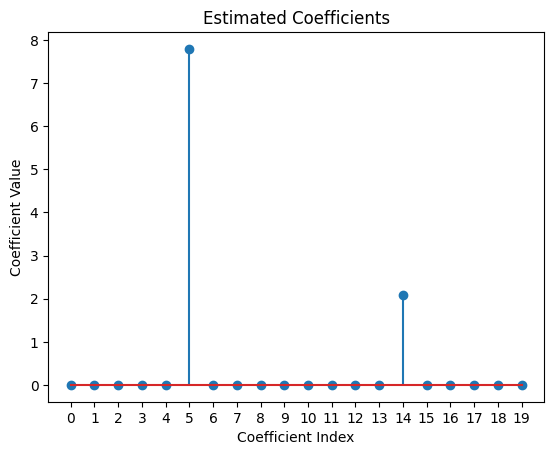

In [21]:
# Plot beta_estimate to demonstrate its sparsity
beta_estimate = model.beta_estimate
plt.stem(range(len(beta_estimate)), beta_estimate)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Estimated Coefficients')
plt.xticks(range(len(beta_estimate)))
plt.show()

This plot shows that there are 2 non-zero parameters.

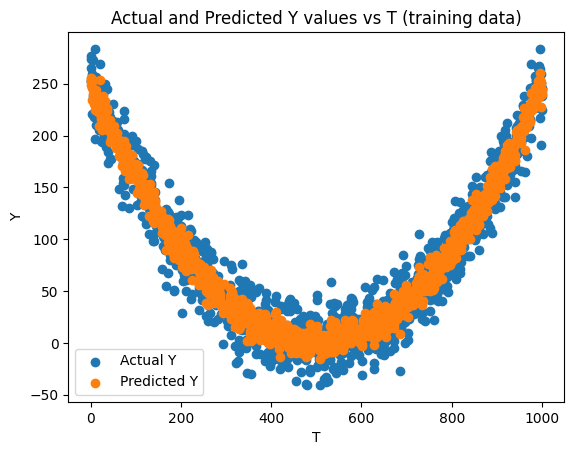

In [22]:
# Plot the training data and predictions against time
Y_train_pred = model.predict(X_train_with_intercept, T_train)
plt.scatter(T_train, Y_train, label='Actual Y')
plt.scatter(T_train, Y_train_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs reasonably well on the training data. There just seems to be a relatively large error term.

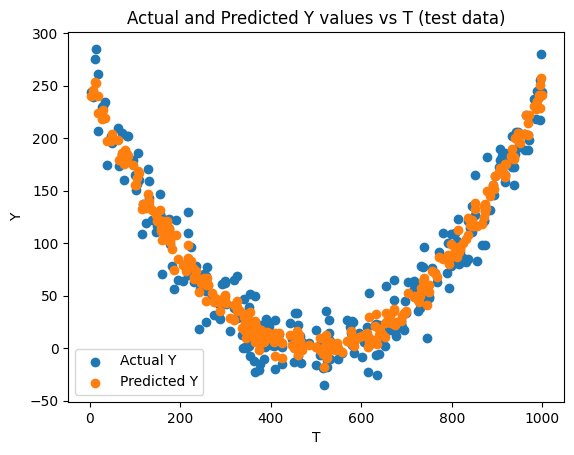

In [23]:
# Plot the test data and predictions against time
X_test_with_intercept = np.column_stack((np.ones_like(T_test), X_test))
Y_test_pred = model.predict(X_test_with_intercept, T_test)
plt.scatter(T_test, Y_test, label='Actual Y')
plt.scatter(T_test, Y_test_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (test data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs similarly on the test data.

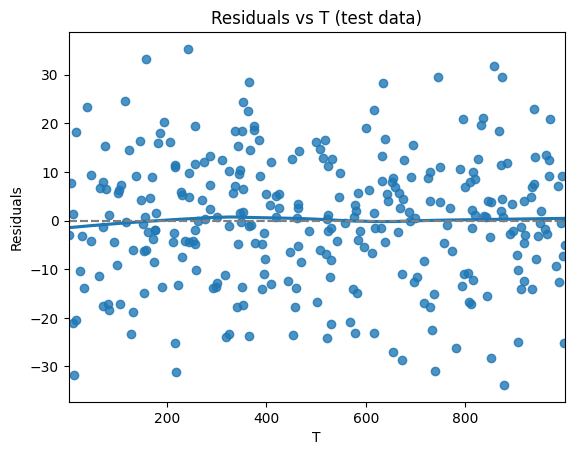

In [24]:
# Plot the test residuals against time
residuals = Y_test_pred - Y_test
sns.residplot(x=T_test, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs T (test data)')
plt.xlabel('T')
plt.ylabel('Residuals')
plt.show()

There is no obvious pattern. This plot therefore indicates that my model captures the relationship between $Y$ and $T$. It also shows that the residuals follow a symmetric distribution centred on zero.

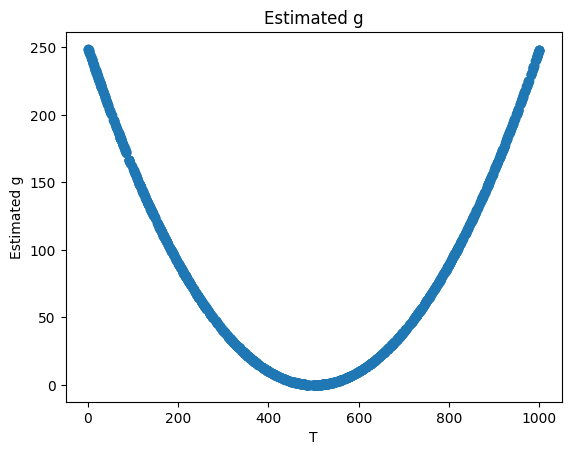

In [25]:
# Plot g_estimate against time
g_estimate_values = model.g_estimate.predict(T.reshape(-1, 1))
plt.scatter(T, g_estimate_values)
plt.xlabel('T')
plt.ylabel('Estimated g')
plt.title('Estimated g')
plt.show()

$\hat{g}$ is smooth and aligns with what we would expect from the plot of $Y$ against $T$.

In [26]:
# Provide the training MSE
mse = mean_squared_error(Y_train, Y_train_pred)
print('Training MSE: ', mse)

Training MSE:  179.50360352937795


In [27]:
# Provide the test MSE
mse = mean_squared_error(Y_test, Y_test_pred)
print('Test MSE: ', mse)

Test MSE:  174.04531618649875


The similarity between the training and test MSE suggests that my model generalises very well.

My model can perform much better than this. The parameters chosen give 2 non-zero parameters in $\beta$ (as per the brief). However, if we remove this requirement, my model can be significantly improved. In the interest of thoroughness, I will also demonstrate this below.

In [28]:
# Approximate g with splines
transformer = SplineTransformer(degree=3, n_knots=2, extrapolation="continue")
# Estimate g via lasso regression
g_specification = make_pipeline(transformer, Lasso(alpha=0.001))

# Fit the backfitting model
model = BackfittingModel(g_specification=g_specification, lambda_1=0.1, lambda_2=0.01)
model.fit(X_train_with_intercept, T_train, Y_train)

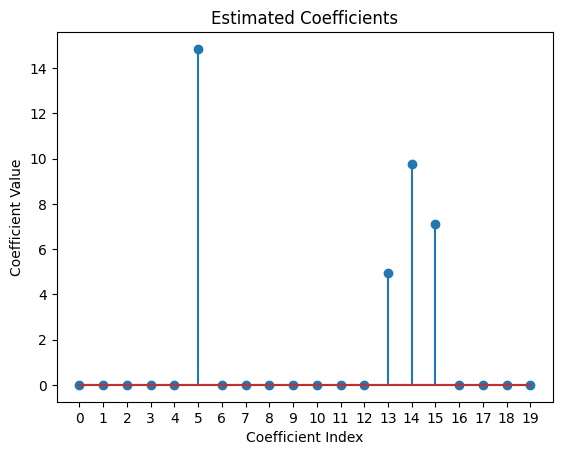

In [29]:
# Plot beta_estimate to demonstrate its sparsity
beta_estimate = model.beta_estimate
plt.stem(range(len(beta_estimate)), beta_estimate)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Estimated Coefficients')
plt.xticks(range(len(beta_estimate)))
plt.show()

This plot shows that there are 4 non-zero parameters.

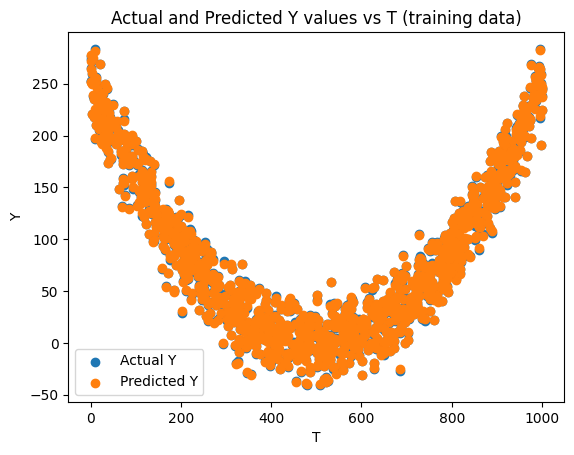

In [30]:
# Plot the training data and predictions against time
Y_train_pred = model.predict(X_train_with_intercept, T_train)
plt.scatter(T_train, Y_train, label='Actual Y')
plt.scatter(T_train, Y_train_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs very well on the training data.

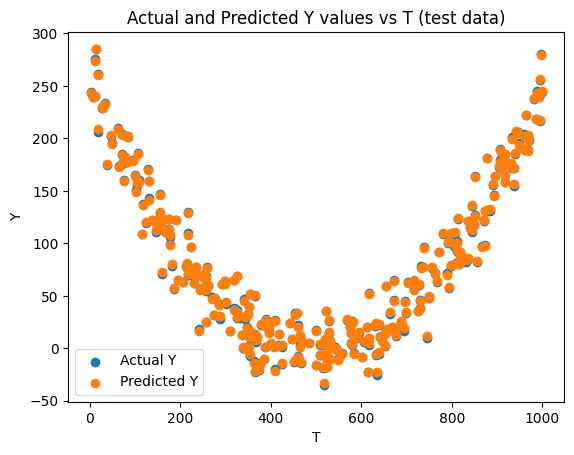

In [31]:
# Plot the test data and predictions against time
X_test_with_intercept = np.column_stack((np.ones_like(T_test), X_test))
Y_test_pred = model.predict(X_test_with_intercept, T_test)
plt.scatter(T_test, Y_test, label='Actual Y')
plt.scatter(T_test, Y_test_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (test data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs similarly on the test data.

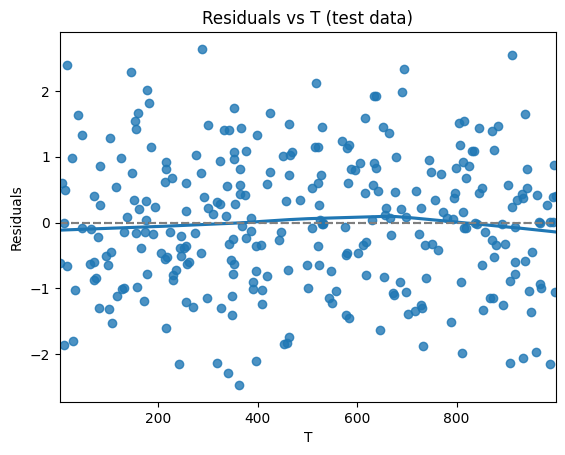

In [32]:
# Plot the test residuals against time
residuals = Y_test_pred - Y_test
sns.residplot(x=T_test, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs T (test data)')
plt.xlabel('T')
plt.ylabel('Residuals')
plt.show()

There is no obvious pattern. This plot therefore indicates that my model captures the relationship between $Y$ and $T$. It also shows that the residuals follow a symmetric distribution centred on zero.

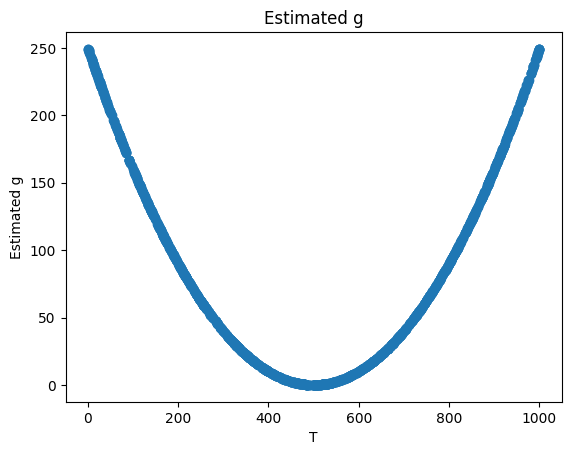

In [33]:
# Plot g_estimate against time
g_estimate_values = model.g_estimate.predict(T.reshape(-1, 1))
plt.scatter(T, g_estimate_values)
plt.xlabel('T')
plt.ylabel('Estimated g')
plt.title('Estimated g')
plt.show()

$\hat{g}$ is smooth and aligns with what we would expect from the plot of $Y$ against $T$.

In [34]:
# Provide the training MSE
mse = mean_squared_error(Y_train, Y_train_pred)
print('Training MSE: ', mse)

Training MSE:  0.9930928645946151


In [35]:
# Provide the test MSE
mse = mean_squared_error(Y_test, Y_test_pred)
print('Test MSE: ', mse)

Test MSE:  1.0593412246417366


The similarity between the training and test MSE suggests that my model generalises very well.

The fact that my model performs so well on both the training and test data with 4 non-zero parameters in $\beta$ leads me to believe that the data was in fact generated with 20% of the entries being non-zero. However, this contradicts the brief so I must conclude that the data was generated with a large error term.

For the scenario where my method performs best (i.e. parameters chosen by hand-tuning), I will demonstrate the method step by step with analysis. For dataset 2, I will provide
- The estimates $\hat{\beta}$ to demonstrate its sparsity;
- The training data and predictions plotted against time;
- The test data and predictions plotted against time;
- The estimated $\hat{g}$ against time; and
- Training and test errors.

In [36]:
# Load data for dataset 2
X = np.loadtxt('data/data2/X.csv', delimiter=',')
T = np.loadtxt('data/data2/T.csv', delimiter=',')
Y = np.loadtxt('data/data2/y.csv', delimiter=',')

# Split the data into training and test sets (take 50% of the data for training)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.5, shuffle=False)

# Add a constant to the model (the intercept term)
X_train_with_intercept = np.column_stack((np.ones_like(T_train), X_train))

In [37]:
# Approximate g with splines
# NOTE: g is periodic
transformer = SplineTransformer(degree=3, n_knots=100, extrapolation="periodic")
# Estimate g via lasso regression
g_specification = make_pipeline(transformer, Lasso(alpha=0.001))

# Fit the backfitting model
model = BackfittingModel(g_specification=g_specification, lambda_1=0.1, lambda_2=0.01)
model.fit(X_train_with_intercept, T_train, Y_train)

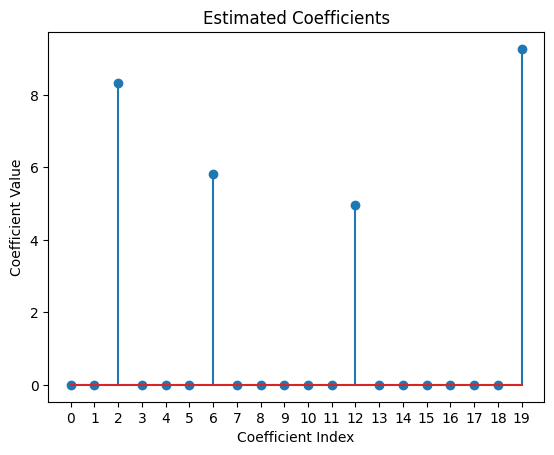

In [38]:
# Plot beta_estimate to demonstrate its sparsity
beta_estimate = model.beta_estimate
plt.stem(range(len(beta_estimate)), beta_estimate)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Estimated Coefficients')
plt.xticks(range(len(beta_estimate)))
plt.show()

This plot shows that there are 4 non-zero parameters.

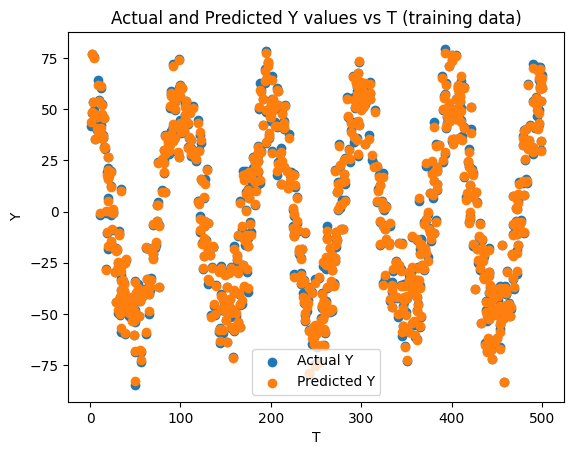

In [39]:
# Plot the training data and predictions against time
Y_train_pred = model.predict(X_train_with_intercept, T_train)
plt.scatter(T_train, Y_train, label='Actual Y')
plt.scatter(T_train, Y_train_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs reasonably well on the training data.

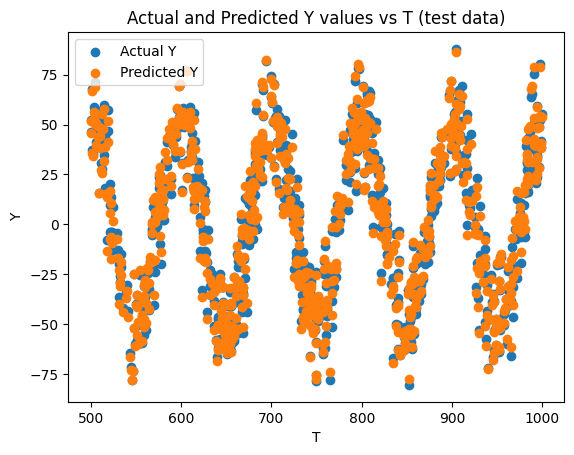

In [40]:
# Plot the test data and predictions against time
X_test_with_intercept = np.column_stack((np.ones_like(T_test), X_test))
Y_test_pred = model.predict(X_test_with_intercept, T_test)
plt.scatter(T_test, Y_test, label='Actual Y')
plt.scatter(T_test, Y_test_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (test data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs reasonably well on the test data. However, it seems that there is a constant error. The residual plot below should help me diagnose the issue.

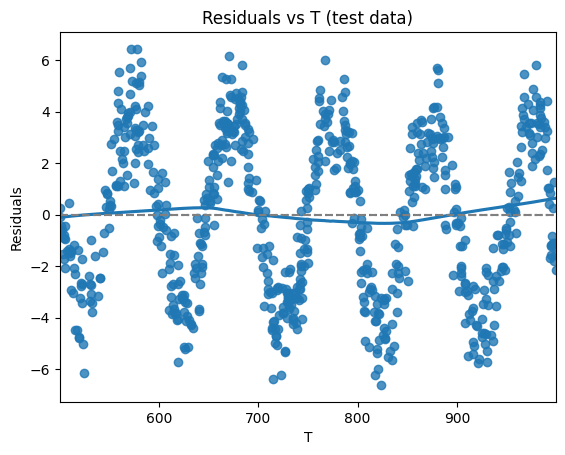

In [41]:
# Plot the test residuals against time
residuals = Y_test_pred - Y_test
sns.residplot(x=T_test, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs T (test data)')
plt.xlabel('T')
plt.ylabel('Residuals')
plt.show()

This plot reveals an issue with my model. The pattern in the residuals occurs because of the implementation of `sklearn.preprocessing.SplineTransformer`. According to the documentation, *"periodic splines with a periodicity equal to the distance between the first and last knot are used"*. Therefore, the period of the extrapolation will be `T_train[-1] - T_train[0] == 498.7580732616558`. By inspection, the period of $g$ is in fact 100. The fact that `T_train[-1] - T_train[0]` is just less than an integer number of periods means that the extrapolation will be very slightly shifted to the left of where it should be and explains the sinusoidal pattern in the residuals.

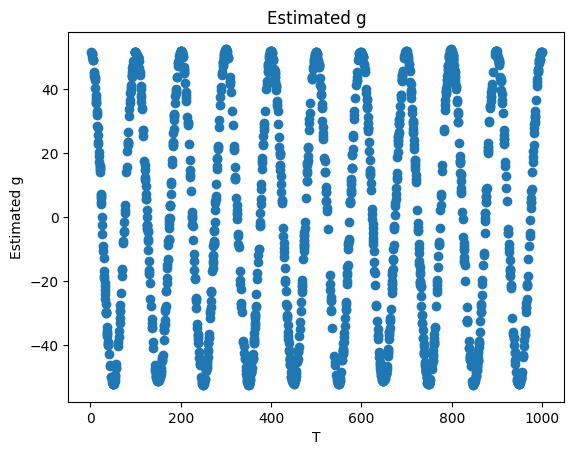

In [42]:
# Plot g_estimate against time
g_estimate_values = model.g_estimate.predict(T.reshape(-1, 1))
plt.scatter(T, g_estimate_values)
plt.xlabel('T')
plt.ylabel('Estimated g')
plt.title('Estimated g')
plt.show()

$\hat{g}$ is smooth and aligns with what we would expect from the plot of $Y$ against $T$.

In [43]:
# Provide the training MSE
mse = mean_squared_error(Y_train, Y_train_pred)
print('Training MSE: ', mse)

Training MSE:  0.86648951381744


In [44]:
# Provide the test MSE
mse = mean_squared_error(Y_test, Y_test_pred)
print('Test MSE: ', mse)

Test MSE:  9.285650709399988


The relatively high value of test MSE is due to the issue described above.

## 5

I will write a K-Fold cross-validation function to select (for simplicity) a single parameter. I will choose the `n_knots` parameter that specifies the number of knots of the splines.

In [45]:
def optimise_n_knots(X, T, Y, n_knots_values):
    '''
    Function to return the average MSE for each value in n_knots_values.
    '''
    # Specify the number of folds for cross-validation
    n_splits = 10
    mse_avg_list = []
    for n_knots in n_knots_values:
        mse_sum = 0
        # Approximate g with splines
        transformer = SplineTransformer(degree=3, n_knots=n_knots, extrapolation="continue")
        # Estimate g via lasso regression
        g_specification = make_pipeline(transformer, Lasso(alpha=0.001))
        # Fit the backfitting model with the current value of n_knots
        model = BackfittingModel(g_specification=g_specification, lambda_1=7, lambda_2=0.01)
        # Perform K-Fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=123456)
        for train_index, test_index in kf.split(X_with_intercept):
            X_train, X_test = X_with_intercept[train_index], X_with_intercept[test_index]
            T_train, T_test = T[train_index], T[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            # Fit model on the training data
            # Suppress convergence warnings
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train, T_train, Y_train)
            # Make predictions on test data
            Y_pred = model.predict(X_test, T_test)
            # Calculate mean squared error
            mse = mean_squared_error(Y_test, Y_pred)
            mse_sum += mse
        # Calculate average mean squared error across all folds
        mse_avg = mse_sum / n_splits
        mse_avg_list.append(mse_avg)
    return mse_avg_list

I will now test this function on dataset 1 and identify the best value of `n_knots` for the model.

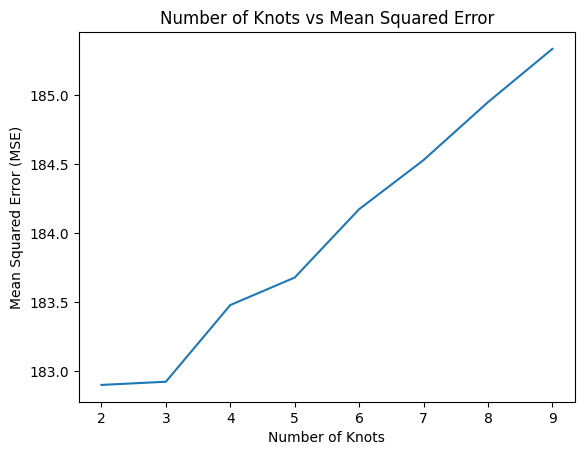

In [46]:
# Load data for dataset 1
X = np.loadtxt('data/data1/X.csv', delimiter=',')
T = np.loadtxt('data/data1/T.csv', delimiter=',')
Y = np.loadtxt('data/data1/y.csv', delimiter=',')

# Add intercept term to X
X_with_intercept = np.column_stack((np.ones_like(T), X))

# Define the range of values for n_knots
n_knots_values = np.arange(2, 10)

mse_avg_list = optimise_n_knots(X, T, Y, n_knots_values)

# Plot n_knots against mean squared error
plt.plot(n_knots_values, mse_avg_list)
plt.xlabel('Number of Knots')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Number of Knots vs Mean Squared Error')
plt.show()

I conclude that the best value of `n_knots` for the model is 2.

## 6

I can replace the splines with a Gaussian process (GP) to model $g$. I will demonstrate in the periodic dataset example how I can replace the spline with a GP object and report my results repeating the plots in 4(c).

In [47]:
# Load data for dataset 2
X = np.loadtxt('data/data2/X.csv', delimiter=',')
T = np.loadtxt('data/data2/T.csv', delimiter=',')
Y = np.loadtxt('data/data2/y.csv', delimiter=',')

# Split the data into training and test sets (take 50% of the data for training)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.5, shuffle=False)

# Add a constant to the model (the intercept term)
X_train_with_intercept = np.column_stack((np.ones_like(T_train), X_train))

In [48]:
# Specify the kernel
# NOTE: I can get an intuition for appropriate values for the parameters below based on the results in 4(c)
kernel = 60 * ExpSineSquared(periodicity=100) + WhiteKernel(noise_level=3)
# Approximate g with a Gaussian process
g_specification = GaussianProcessRegressor(kernel=kernel)

# Fit the backfitting model
model = BackfittingModel(g_specification=g_specification, lambda_1=0.1, lambda_2=0.01)
model.fit(X_train_with_intercept, T_train, Y_train)

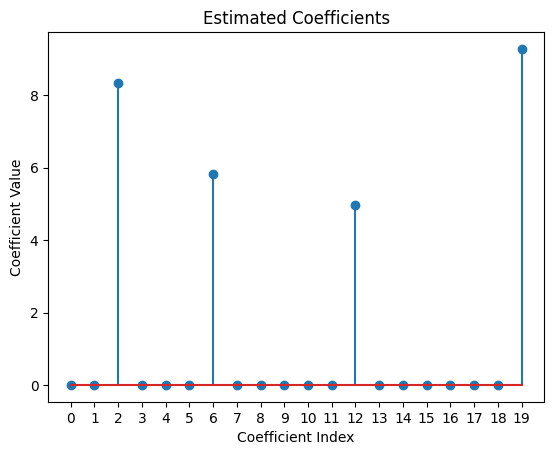

In [49]:
# Plot beta_estimate to demonstrate its sparsity
beta_estimate = model.beta_estimate
plt.stem(range(len(beta_estimate)), beta_estimate)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Estimated Coefficients')
plt.xticks(range(len(beta_estimate)))
plt.show()

This plot shows that there are 4 non-zero parameters.

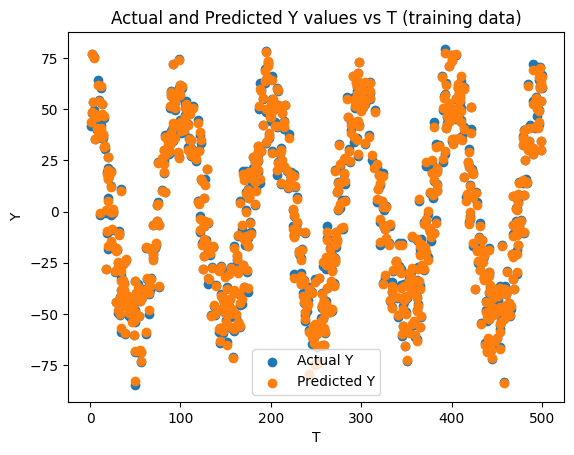

In [50]:
# Plot the training data and predictions against time
Y_train_pred = model.predict(X_train_with_intercept, T_train)
plt.scatter(T_train, Y_train, label='Actual Y')
plt.scatter(T_train, Y_train_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (training data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs very well on the training data.

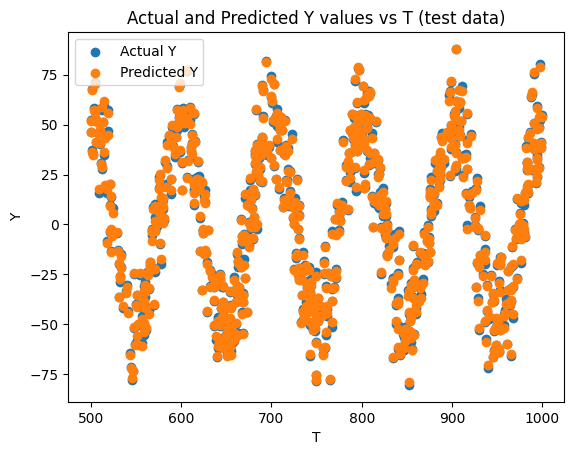

In [51]:
# Plot the test data and predictions against time
X_test_with_intercept = np.column_stack((np.ones_like(T_test), X_test))
Y_test_pred = model.predict(X_test_with_intercept, T_test)
plt.scatter(T_test, Y_test, label='Actual Y')
plt.scatter(T_test, Y_test_pred, label='Predicted Y')
plt.title('Actual and Predicted Y values vs T (test data)')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

This plot indicates that my model performs similarly on the test data.

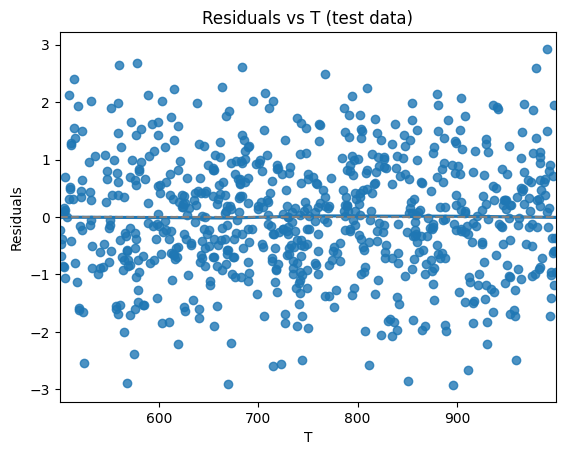

In [52]:
# Plot the test residuals against time
residuals = Y_test_pred - Y_test
sns.residplot(x=T_test, y=residuals, lowess=True)
plt.axhline(0, color='grey', linestyle='dashed')
plt.title('Residuals vs T (test data)')
plt.xlabel('T')
plt.ylabel('Residuals')
plt.show()

There is no obvious pattern. This plot therefore indicates that my model captures the relationship between $Y$ and $T$. It also shows that the residuals follow a symmetric distribution centred on zero.

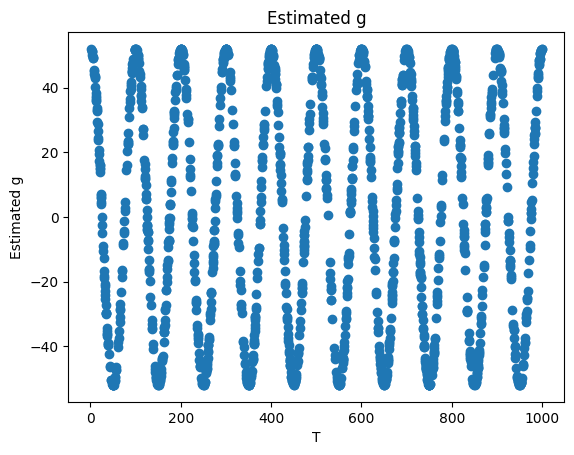

In [53]:
# Plot g_estimate against time
g_estimate_values = model.g_estimate.predict(T.reshape(-1, 1))
plt.scatter(T, g_estimate_values)
plt.xlabel('T')
plt.ylabel('Estimated g')
plt.title('Estimated g')
plt.show()

$\hat{g}$ is smooth and aligns with what we would expect from the plot of $Y$ against $T$.

In [54]:
# Provide the training MSE
mse = mean_squared_error(Y_train, Y_train_pred)
print('Training MSE: ', mse)

Training MSE:  0.9861106217160861


In [55]:
# Provide the test MSE
mse = mean_squared_error(Y_test, Y_test_pred)
print('Test MSE: ', mse)

Test MSE:  1.0933489538049557


The similarity between the training and test MSE suggests that my model generalises very well.

## 7

Conclusions:
- The pure linear model is not a good fit for dataset 1 or dataset 2. It is unable to model the nonlinear relationship between $Y$ and $T$.
- Estimating $g$ with splines works well for dataset 1, where I used 2 non-zero parameters in $\beta$ (as per the brief).
- However, further investigation leads me to believe that dataset 1 was in fact generated with 4 non-zero parameters in $\beta$. However, this contradicts the brief so I must conclude that the data was generated with a large error term.
- Estimating $g$ with splines works reasonably well for dataset 2. However, there is a sinusoidal pattern in the residuals due to the implementation of `sklearn.preprocessing.SplineTransformer`. This is an example of problematic behaviour of my method and when it fails. I could potentially improve this by manually setting the knot values to control the period.
- Replacing the splines with a Gaussian process removed the sinusoidal pattern in the residuals for dataset 2. Reassuringly, the rest of the results are broadly aligned.